# TM-G testing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv('Data/hourly_data_ff.csv')
time = df['timestamp']
df.drop(columns=['timestamp'], inplace=True)

In [163]:
dfs = np.array_split(df,10)
times = np.array_split(time,10)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


The Granger causality test indicates that the only orderbook features that cause the volatility are ask_depth, bid_depth, bid_volume, spread and volume_difference. We thus train the model using only these features.


In [ ]:
from Models.TM_G import TM_G
from Model_eval.TM_eval import evaluate_TM
from sklearn.preprocessing import StandardScaler
from Models.CVal import cross_validation
import copy

feature_cols = df.columns.difference(['vol'])
predictions = []
for i in range(4, 9):
  df_train = pd.concat([copy.deepcopy(dfs[j]) for j in range(i-3,i-1)], ignore_index=True).reset_index(drop = True)
  df_validate = copy.deepcopy(dfs[i])
  df_test =copy.deepcopy(dfs[i+1])

  best_params = cross_validation(copy.deepcopy(df_train), copy.deepcopy(df_validate))
  print(f'Cross validated interval {i}')

  model = TM_G(n_features = df_train.shape[1]-1, lb = best_params['lb'], lambda_reg = best_params['lambda_reg'])
  new_df_train = pd.concat([df_train, df_validate], axis=0, ignore_index=True).reset_index(drop = True)
  scaler = StandardScaler()
  new_df_train[feature_cols] = scaler.fit_transform(new_df_train[feature_cols])
  model.train_model(df_train, epochs = 2000)
  df_test[feature_cols] = scaler.transform(df_test[feature_cols])
  print(f'Predicted interval {i+1}')

  _, _, y_pred, _ = evaluate_TM(model, df_test, plot = False)
  predictions.append(y_pred)

100%|██████████| 2000/2000 [00:03<00:00, 624.90it/s]


Cross validated interval 4


100%|██████████| 2000/2000 [00:01<00:00, 1027.76it/s]


Predicted interval 5


100%|██████████| 2000/2000 [00:03<00:00, 663.67it/s]


Cross validated interval 5


100%|██████████| 2000/2000 [00:02<00:00, 873.64it/s]


Predicted interval 6


100%|██████████| 2000/2000 [00:03<00:00, 552.97it/s]


Cross validated interval 6


100%|██████████| 2000/2000 [00:02<00:00, 826.87it/s]


Predicted interval 7


100%|██████████| 2000/2000 [00:03<00:00, 655.85it/s]


Cross validated interval 7


100%|██████████| 2000/2000 [00:02<00:00, 916.94it/s] 


Predicted interval 8


100%|██████████| 2000/2000 [00:03<00:00, 650.24it/s]


Cross validated interval 8


100%|██████████| 2000/2000 [00:02<00:00, 669.94it/s]

Predicted interval 9


In [ ]:
final_pred = [predictions[j][i] for j in range(1,len(predictions)) for i in range(len(predictions[j])) ]
print(len(final_pred))
dfs = [dfs[i][31:] for i in range(10)]
merged = pd.concat(dfs[5:], ignore_index=True).reset_index(drop = True)
print(merged.shape)

1145
(1145, 11)


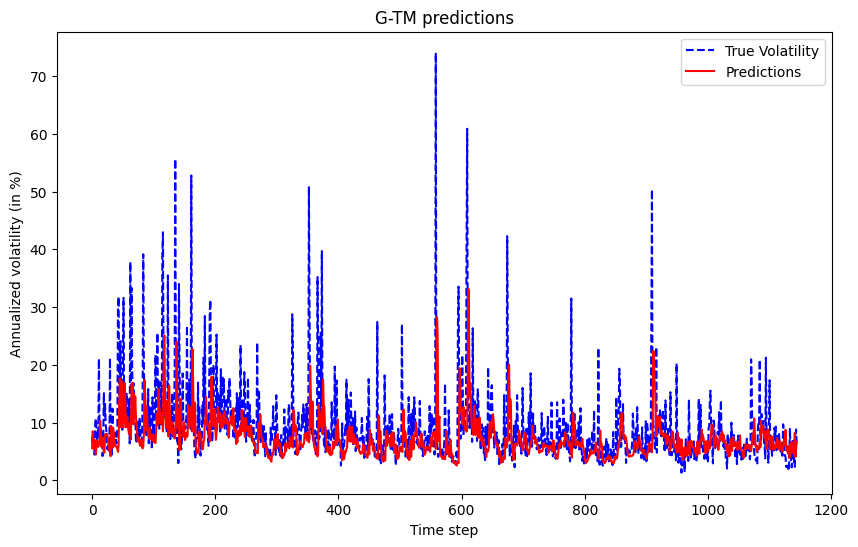

In [165]:
plt.figure(figsize = (10,6))
plt.plot( merged['vol'], label = 'True Volatility', color = 'blue', linestyle = '--')
plt.plot( final_pred, label = 'Predictions', color = 'red')
plt.title('G-TM predictions')
plt.ylabel('Annualized volatility (in %)')
plt.xlabel('Time step')
plt.legend()
plt.show()

In [166]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
for i in range(5,10):
  start = int(np.sum([len(dfs[j]) for j in range(5, i)]))
  rmse = np.sqrt(mean_squared_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])])) / 100 # Undo percentage scaling
  mae = mean_absolute_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])]) / 100 
  print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Test RMSE: 0.0907, MAE: 0.0541
Test RMSE: 0.0637, MAE: 0.0374
Test RMSE: 0.0873, MAE: 0.0428
Test RMSE: 0.0531, MAE: 0.0281
Test RMSE: 0.0363, MAE: 0.0243


In [167]:
dfs = np.array_split(df,10)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


We now check if adding our remaining features lead to improved performance.

In [15]:
predictions = []
for i in range(4, 9):
  df_train = pd.concat([copy.deepcopy(dfs[j]) for j in range(i-3,i-1)], ignore_index=True).reset_index(drop = True)
  df_validate = copy.deepcopy(dfs[i])
  df_test =copy.deepcopy(dfs[i+1])

  best_params = cross_validation(copy.deepcopy(df_train), copy.deepcopy(df_validate))
  print(f'Cross validated interval {i}')

  model = TM_G(n_features = df_train.shape[1]-1, lb = best_params['lb'], lambda_reg = best_params['lambda_reg'])
  new_df_train = pd.concat([df_train, df_validate], axis=0, ignore_index=True).reset_index(drop = True)
  scaler = StandardScaler()
  new_df_train[feature_cols] = scaler.fit_transform(new_df_train[feature_cols])
  model.train_model(df_train, epochs = 2000)
  df_test[feature_cols] = scaler.transform(df_test[feature_cols])
  print(f'Predicted interval {i+1}')

  _, _, y_pred, _ = evaluate_TM(model, df_test, plot = False)
  predictions.append(y_pred)

100%|██████████| 2000/2000 [00:03<00:00, 643.87it/s]


Cross validated interval 4


100%|██████████| 2000/2000 [00:03<00:00, 626.00it/s]


Predicted interval 5


100%|██████████| 2000/2000 [00:03<00:00, 658.67it/s]


Cross validated interval 5


100%|██████████| 2000/2000 [00:02<00:00, 981.36it/s] 


Predicted interval 6


100%|██████████| 2000/2000 [00:04<00:00, 499.47it/s]


Cross validated interval 6


100%|██████████| 2000/2000 [00:02<00:00, 920.42it/s] 


Predicted interval 7


100%|██████████| 2000/2000 [00:03<00:00, 511.02it/s]


Cross validated interval 7


100%|██████████| 2000/2000 [00:02<00:00, 748.46it/s]


Predicted interval 8


100%|██████████| 2000/2000 [00:03<00:00, 545.31it/s]


Cross validated interval 8


100%|██████████| 2000/2000 [00:01<00:00, 1021.96it/s]

Predicted interval 9


In [ ]:
final_pred = [predictions[j][i] for j in range(1,len(predictions)) for i in range(len(predictions[j])) ]
print(len(final_pred))
dfs = [dfs[i][31:] for i in range(10)]
merged = pd.concat(dfs[5:], ignore_index=True).reset_index(drop = True)
print(merged.shape)

1145
(1145, 11)


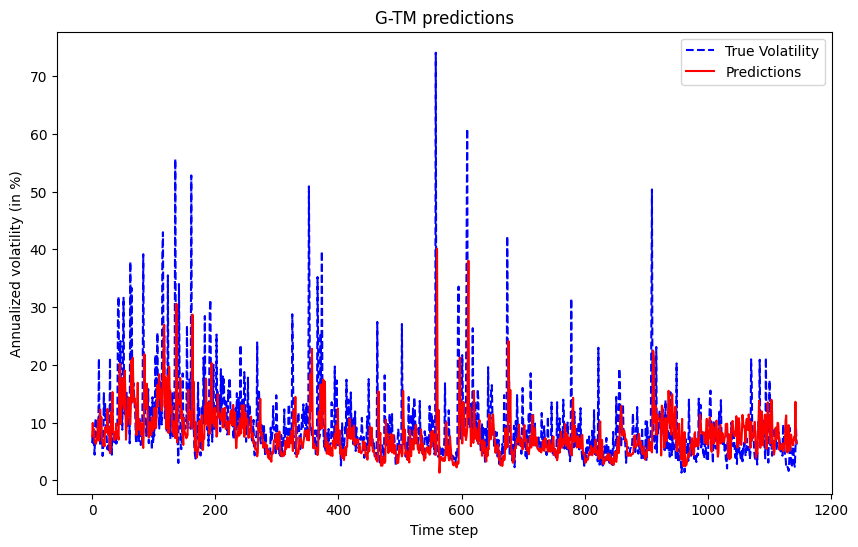

In [175]:
plt.figure(figsize = (10,6))
plt.plot( merged['vol'], label = 'True Volatility', color = 'blue', linestyle = '--')
plt.plot( final_pred, label = 'Predictions', color = 'red')
plt.title('G-TM predictions')
plt.ylabel('Annualized volatility (in %)')
plt.xlabel('Time step')
plt.legend()
plt.show()

In [177]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
for i in range(5,10):
  start = int(np.sum([len(dfs[j]) for j in range(5, i)]))
  rmse = np.sqrt(mean_squared_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])])) / 100 # Undo percentage scaling
  mae = mean_absolute_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])]) / 100 
  print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Test RMSE: 0.0873, MAE: 0.0541
Test RMSE: 0.0641, MAE: 0.0383
Test RMSE: 0.0904, MAE: 0.0451
Test RMSE: 0.0532, MAE: 0.0293
Test RMSE: 0.0436, MAE: 0.0330


# Sentiment TM-G testing

The granger causality test indicates that our sentiment time series Granger-causes the volatility up to two lags, so we choose the look back window for the sentiment component to be 2.

In [2]:
sent = pd.read_csv('Data/sentiment.csv')

In [128]:
dfs = np.array_split(df,10)
"""sents = np.array_split(sent,10)

for i in range(10):
    dfs[i]['sentiment'] = sents[i]['Aggregate sentiment'].values"""


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


"sents = np.array_split(sent,10)\n\nfor i in range(10):\n    dfs[i]['sentiment'] = sents[i]['Aggregate sentiment'].values"

In [10]:
import matplotlib.pyplot as plt
from Models.TM_SG import TM_SG
from Model_eval.TM_eval import evaluate_STM
from sklearn.preprocessing import StandardScaler
from Models.CVal import cross_validation
import copy
feature_cols = df.columns.difference(['vol', 'sentiment'])
predictions = []
for i in range(4, 9):
  df_train = pd.concat([copy.deepcopy(dfs[j]) for j in range(i-3,i-1)], ignore_index=True).reset_index(drop = True)
  df_validate = copy.deepcopy(dfs[i])
  df_test =copy.deepcopy(dfs[i+1])

  best_params = cross_validation(copy.deepcopy(df_train), copy.deepcopy(df_validate))
  print(f'Cross validated interval {i}')

  model = TM_SG(n_features = len(feature_cols), lb = best_params['lb'], lambda_reg = best_params['lambda_reg'])
  new_df_train = pd.concat([df_train, df_validate], axis=0, ignore_index=True).reset_index(drop = True)
  scaler = StandardScaler()
  new_df_train[feature_cols] = scaler.fit_transform(new_df_train[feature_cols])
  model.train_model(df_train, epochs = 2000)
  df_test[feature_cols] = scaler.transform(df_test[feature_cols])
  print(f'Predicted interval {i+1}')

  _, _, y_pred = evaluate_STM(model, df_test, plot = False)
  predictions.append(y_pred)

100%|██████████| 2000/2000 [00:03<00:00, 652.77it/s]


Cross validated interval 4


100%|██████████| 2000/2000 [00:04<00:00, 465.06it/s]


Predicted interval 5


100%|██████████| 2000/2000 [00:02<00:00, 696.76it/s]


Cross validated interval 5


100%|██████████| 2000/2000 [00:02<00:00, 864.77it/s]


Predicted interval 6


100%|██████████| 2000/2000 [00:03<00:00, 604.08it/s]


Cross validated interval 6


100%|██████████| 2000/2000 [00:03<00:00, 654.14it/s]


Predicted interval 7


100%|██████████| 2000/2000 [00:03<00:00, 636.84it/s]


Cross validated interval 7


100%|██████████| 2000/2000 [00:02<00:00, 861.18it/s]


Predicted interval 8


100%|██████████| 2000/2000 [00:03<00:00, 505.03it/s]


Cross validated interval 8


100%|██████████| 2000/2000 [00:06<00:00, 315.63it/s]


Predicted interval 9


In [ ]:
final_pred = [predictions[j][i] for j in range(len(predictions)) for i in range(len(predictions[j])) ]
print(len(final_pred))
dfs = [dfs[i][31:] for i in range(10)]
merged = pd.concat(dfs[5:], ignore_index=True).reset_index(drop = True)
print(merged.shape)

1145
(1145, 11)


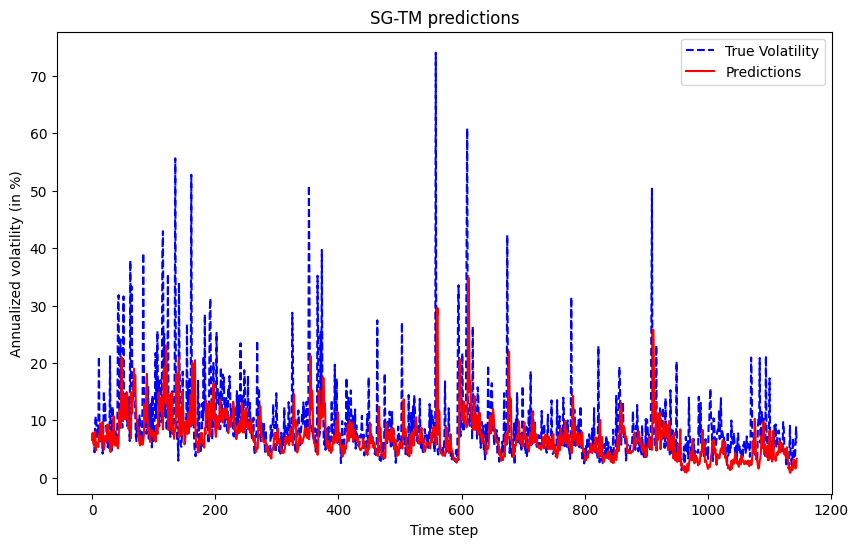

In [140]:
plt.figure(figsize = (10,6))
plt.plot( merged['vol'], label = 'True Volatility', color = 'blue', linestyle = '--')
plt.plot( final_pred, label = 'Predictions', color = 'red')
plt.title('SG-TM predictions')
plt.ylabel('Annualized volatility (in %)')
plt.xlabel('Time step')
plt.legend()
plt.show()

In [149]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
for i in range(5,10):
  start = int(np.sum([len(dfs[j]) for j in range(5, i)]))
  rmse = np.sqrt(mean_squared_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])])) / 100 # Undo percentage scaling
  mae = mean_absolute_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])]) / 100 
  print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Test RMSE: 0.0907, MAE: 0.0553
Test RMSE: 0.0633, MAE: 0.0371
Test RMSE: 0.0881, MAE: 0.0436
Test RMSE: 0.0536, MAE: 0.0297
Test RMSE: 0.0463, MAE: 0.0326


# LSTMX

# HAR models

[Window 1] Selected windows: [1, 2, 3, 25, 28]
[Window 2] Selected windows: [1, 2, 28]
[Window 3] Selected windows: [1, 2, 15, 27, 29]
[Window 4] Selected windows: [1, 2, 16, 27]
[Window 5] Selected windows: [1, 2, 21, 27, 29]
[Window 6] Selected windows: [1, 7, 21, 27, 29]


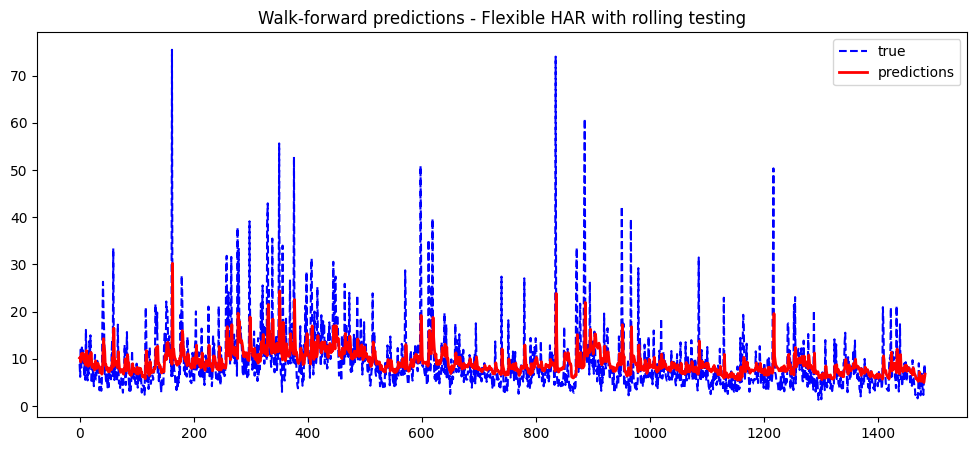

[Window 1] Selected windows: [1, 6, 24]
[Window 2] Selected windows: [1, 6, 24]
[Window 3] Selected windows: [1, 6, 24]
[Window 4] Selected windows: [1, 6, 24]
[Window 5] Selected windows: [1, 6, 24]
[Window 6] Selected windows: [1, 6, 24]


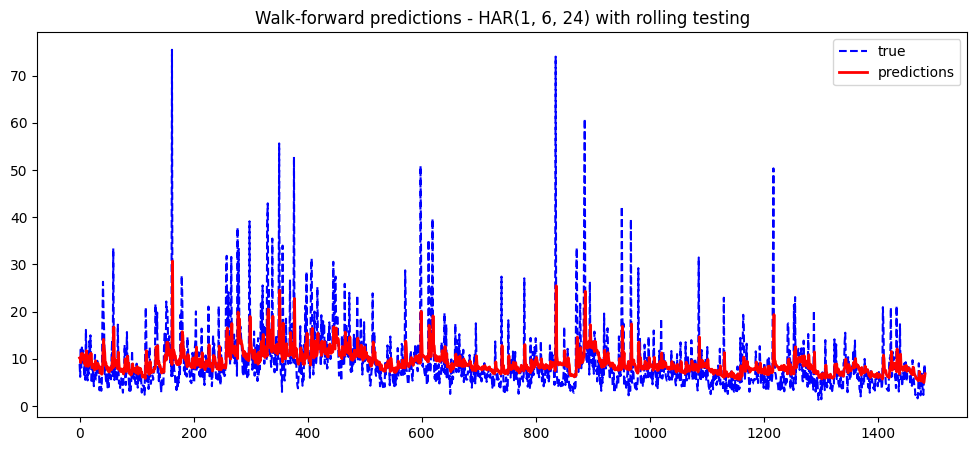

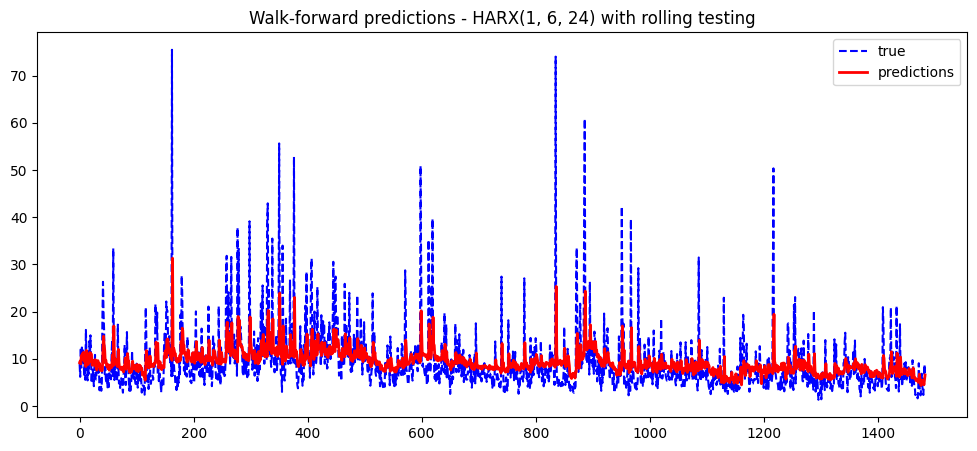

,window,MAE,RMSE,Used Windows
0,1,0.041409,0.067449,"[1, 6, 24]"
1,2,0.042284,0.069541,"[1, 6, 24]"
2,3,0.035088,0.064986,"[1, 6, 24]"
3,4,0.037212,0.060810,"[1, 6, 24]"
4,5,0.029107,0.044057,"[1, 6, 24]"
5,6,0.025619,0.036854,"[1, 6, 24]"


In [180]:
from Models.HAR import *
from Models.HARX import *

Y = df['vol'].values


sim1 = HARSimulator(df=df, Y=Y, shift=1, mode='rolling', use_lasso=True)
sim1.add_rolling_features()
sim1.run_simulation()
sim1.plot_predictions()
sim1.summary()

sim2 = HARSimulator(df=df, Y=Y, shift=1, mode='rolling', use_lasso=False, fixed_windows=[1, 6, 24])
sim2.add_rolling_features()
sim2.run_simulation()
sim2.plot_predictions()
sim2.summary()

sim3 = HARXSimulator(df=df, Y=Y, shift=1, mode='rolling')
sim3.add_rolling_features()
sim3.run_simulation()
sim3.plot_predictions()
sim3.summary()

# GARCH

In [2]:
df_returns = pd.read_csv(
    'Data/hourly_data_ff_with_returns.csv',
    parse_dates=['timestamp']
)
df_vol = pd.read_csv(
    'Data/hourly_data_ff.csv',
    parse_dates=['timestamp']
)

Starting lookback window cross validation...
Finished cross validation.
Starting volatility prediction ...

Mean RMSE for each of the 10 intervals:
Interval 1: 0.06157
Interval 2: 0.06470
Interval 3: 0.06026
Interval 4: 0.04821
Interval 5: 0.06100
Interval 6: 0.06954
Interval 7: 0.05216
Interval 8: 0.05634
Interval 9: 0.03794
Interval 10: 0.03841


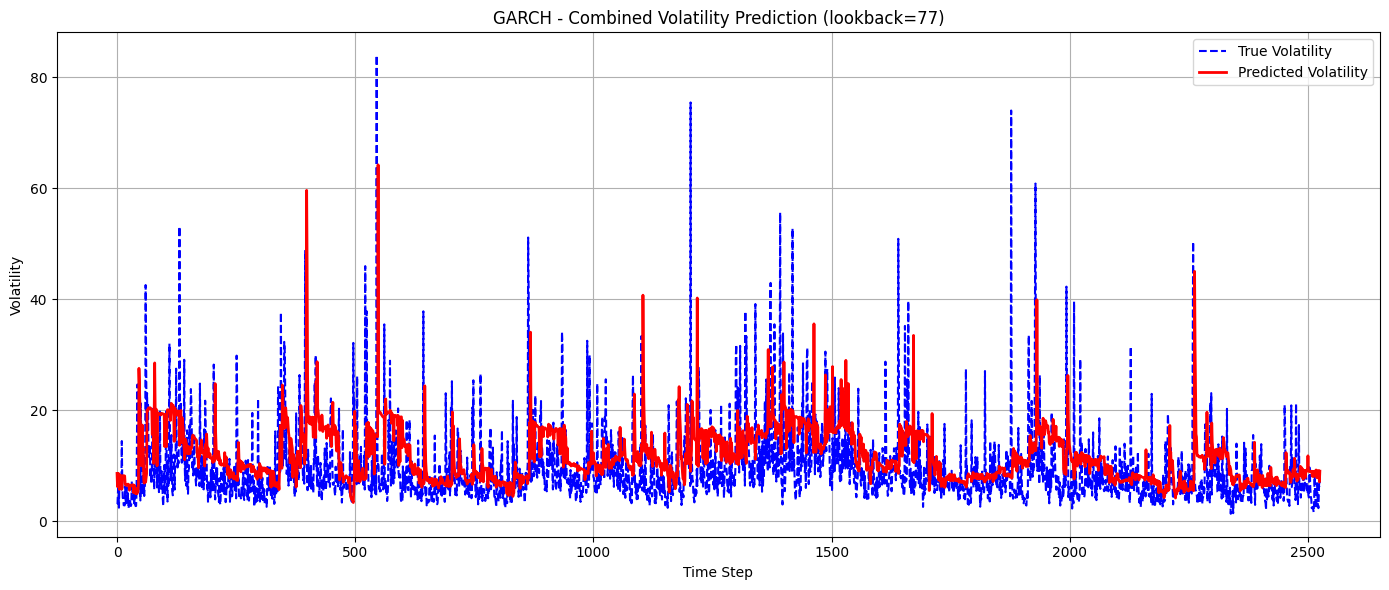

In [3]:
from Models.GARCH import test_garch
results_df, mean_rmse_intervals = test_garch(df_returns, df_vol)

# XGBoost



[Window 1] Training on intervals 0-2, validating on 3, testing on 4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



[Window 2] Training on intervals 1-3, validating on 4, testing on 5

[Window 3] Training on intervals 2-4, validating on 5, testing on 6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



[Window 4] Training on intervals 3-5, validating on 6, testing on 7

[Window 5] Training on intervals 4-6, validating on 7, testing on 8

[Window 6] Training on intervals 5-7, validating on 8, testing on 9


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



[Summary]
   Window      RMSE       MAE
0       1  0.080493  6.242220
1       2  0.081038  5.267569
2       3  0.061265  4.215007
3       4  0.071477  4.442153
4       5  0.056649  3.787610
5       6  0.061476  5.177308


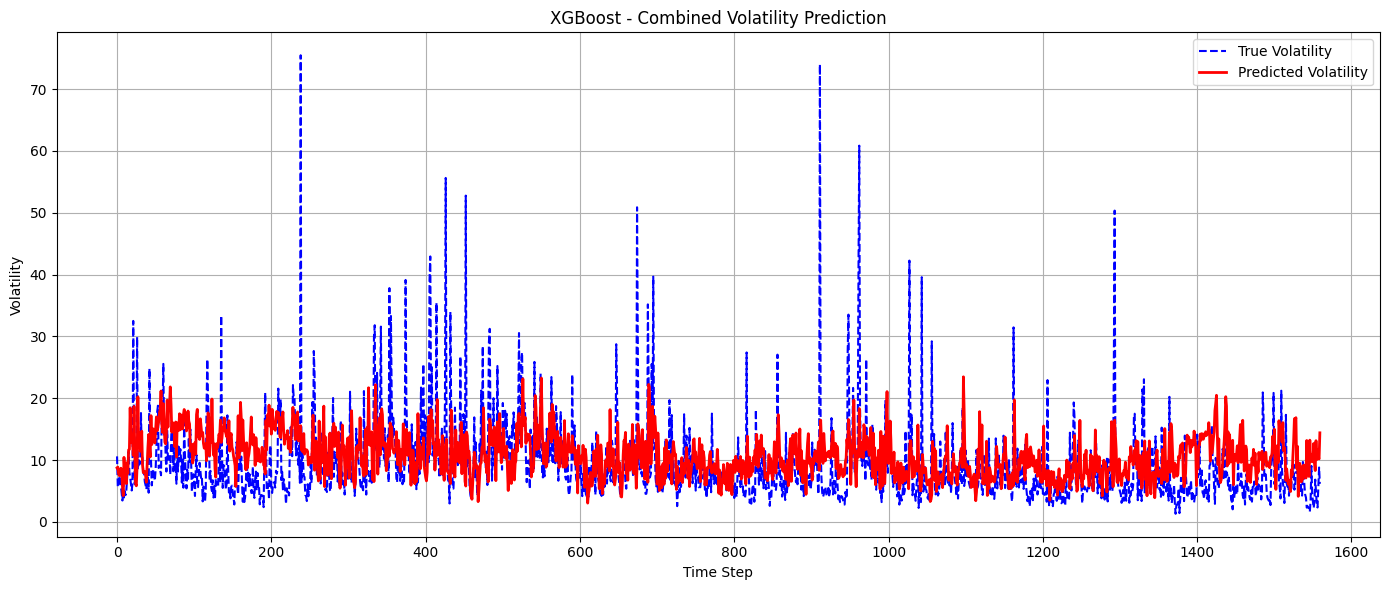

,Window,RMSE,MAE
0,1,0.080493,6.242220
1,2,0.081038,5.267569
2,3,0.061265,4.215007
3,4,0.071477,4.442153
4,5,0.056649,3.787610
5,6,0.061476,5.177308


In [2]:
from Models.XGBoost import *

df = pd.read_csv('Data/hourly_data_ff.csv')
df = df.drop(columns=['timestamp']) 

test_xgboost(df)